# MCCoder API QA Dataset for evaluation


## Preparation


### Congregate the instruction part with python api.


In [48]:
import pandas as pd

# Load the first Excel file with specific data types
file1_path = 'docs/WMX3API c++ to python list -all2.xlsx'
df1 = pd.read_excel(file1_path, dtype=str)

# Load the second Excel file with specific data types
file2_path = 'docs/table-data(Api)2.xlsx'
df2 = pd.read_excel(file2_path, dtype=str)

In [ ]:
# Define the column names
function_cpp_column = 'FunctionC++'
api_name_column = 'APINAME'
instruction_column = 'INSTRUCTION'
instruction_output_column = 'Instruction'

# Add a new 'Instruction' column to df1 if it doesn't exist
if instruction_output_column not in df1.columns:
    df1[instruction_output_column] = ""

# Process each row in df1
for index, row in df1.iterrows():
    function_cpp = row[function_cpp_column]
    
    if pd.notnull(function_cpp):
        api_function = None
        if 'WMX3APIFUNC ' in function_cpp:
            # Get the substring after 'WMX3APIFUNC '
            api_function = function_cpp.split('WMX3APIFUNC ')[1].strip()
        elif function_cpp.startswith('bool '):
            # Get the substring after 'bool '
            api_function = function_cpp.split('bool ')[1].strip()
        elif 'ECAPIFUNC ' in function_cpp:
            # Get the substring after 'WMX3APIFUNC '
            api_function = function_cpp.split('ECAPIFUNC ')[1].strip()
        elif 'CCLINKAPIFUNC ' in function_cpp:
            # Get the substring after 'WMX3APIFUNC '
            api_function = function_cpp.split('CCLINKAPIFUNC ')[1].strip()
        
        if api_function:
            print(f"Processing FunctionC++: {function_cpp}, Extracted API Function: {api_function}")
            
            # Search for the substring in the APINAME column of df2
            matching_row = df2[df2[api_name_column] == api_function]
            
            if not matching_row.empty:
                # Get the INSTRUCTION from the matching row
                instruction = matching_row[instruction_column].values[0]
                print(f"Found matching APINAME: {api_function}, Instruction: {instruction}")
                
                # Update the Instruction column in df1
                df1.at[index, instruction_output_column] = instruction
            else:
                print(f"No matching APINAME found for: {api_function}")


# Save the updated df1 back to the Excel file
# output_file_path = 'docs/WMX3API c++ to python list -all3.xlsx'
df1.to_excel(file1_path, index=False)
print(f"Updated file saved to {file1_path}")

## Dataset


## BM25 for C, not use

In [59]:
import pandas as pd
import random
from rank_bm25 import BM25Okapi
import numpy as np

# Load the input data file
input_file_path = "docs/WMX3API_CleanedData.xlsx"
data = pd.read_excel(input_file_path)

# Remove leading and trailing whitespace from the 'Instruction' column
data['Instruction'] = data['Instruction'].str.strip()

# Remove 'def ' from the 'FunctionPython' column
data['FunctionPython'] = data['FunctionPython'].str.replace('def ', '')

# Remove any rows with NaN values in critical columns
data.dropna(subset=['FunctionPython', 'Class'], inplace=True)

# Initialize an empty list to store the QA entries
qa_entries = []

# Filter rows where 'Instruction' and 'FunctionPython' are not blank
filtered_data = data.dropna(subset=['Instruction', 'FunctionPython'])

# Tokenize the FunctionPython column for BM25
tokenized_functions = [func.split() for func in data['FunctionPython'].dropna().tolist()]

# Initialize BM25
bm25 = BM25Okapi(tokenized_functions)

# Iterate through each filtered row to create QA entries
for idx, row in filtered_data.iterrows():
    # Create a dictionary to store the QA entry
    qa_entry = {
        'No': len(qa_entries) + 1,
        'Instruction': row['Instruction'],
        'A': row['FunctionPython']
    }
    
    # Find all functions with the same 'Class' as the current row
    same_class_functions = data[data['Class'] == row['Class']]['FunctionPython'].dropna().tolist()
    
    # Remove the current function from the list
    same_class_functions = [func for func in same_class_functions if func != row['FunctionPython']]
    
    # Randomly choose one function from the same class for option B
    if same_class_functions:
        qa_entry['B'] = random.choice(same_class_functions)
    else:
        qa_entry['B'] = "No alternative function available"
    
    # Find 5 similar functions using BM25 for option C
    query = row['FunctionPython'].split()
    scores = bm25.get_scores(query)
    
    # Get the top 5 similar functions, excluding the current function and avoiding duplicates
    top_5_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
    top_5_functions = []
    for i in top_5_indices:
        func = data['FunctionPython'].iloc[i]
        if func != row['FunctionPython'] and func not in top_5_functions and not pd.isna(func):
            top_5_functions.append(func)
        if len(top_5_functions) == 5:
            break
    
    # Print the top 5 similar functions
    print(f"Top 5 similar functions for '{row['FunctionPython']}':")
    for func in top_5_functions:
        print(func)
    print()
    
    # Randomly choose one from the top 5 for option C
    if top_5_functions:
        qa_entry['C'] = random.choice(top_5_functions)
    else:
        qa_entry['C'] = "No similar function available"
    
    # Add placeholder option for D
    qa_entry['D'] = "Option D placeholder"
    
    # Append the QA entry to the list
    qa_entries.append(qa_entry)

# Create a DataFrame for the QA dataset
qa_dataset = pd.DataFrame(qa_entries)

# Define the output file path
output_file_path = "docs/WMX3API_QA_Dataset.xlsx"

# Write the QA dataset to the output file
qa_dataset.to_excel(output_file_path, index=False)

print(f"QA dataset has been written to {output_file_path}")


Top 5 similar functions for 'ApiLogToString(pLogData, logDataSize) ':
GetLibVersion() 
IsDeviceValid() 
GetVersion() 
CreateApiBuffer(channel, size) 
CreateApiBuffer(channel) 

Top 5 similar functions for 'GetLibVersion() ':
ApiLogToString(pLogData, logDataSize) 
IsDeviceValid() 
GetVersion() 
CreateApiBuffer(channel, size) 
CreateApiBuffer(channel) 

Top 5 similar functions for 'IsDeviceValid() ':
ApiLogToString(pLogData, logDataSize) 
GetLibVersion() 
GetVersion() 
CreateApiBuffer(channel, size) 
CreateApiBuffer(channel) 

Top 5 similar functions for 'GetVersion() ':
ApiLogToString(pLogData, logDataSize) 
GetLibVersion() 
IsDeviceValid() 
CreateApiBuffer(channel, size) 
CreateApiBuffer(channel) 

Top 5 similar functions for 'CreateApiBuffer(channel, size) ':
CreateApiBuffer(channel, size, sizeUnit) 
GetInBytes(addr, size) 
GetOutBytes(addr, size) 
GetInBytesEx(addr, size) 
GetOutBytesEx(addr, size) 

Top 5 similar functions for 'CreateApiBuffer(channel) ':
ApiLogToString(pLogData, lo

## FUZZ MAtching for C, much better than BM25

In [62]:
import pandas as pd
import random
from fuzzywuzzy import fuzz, process

# Load the input data file
input_file_path = "docs/WMX3API_CleanedData.xlsx"
data = pd.read_excel(input_file_path)

# Remove leading and trailing whitespace from the 'Instruction' column
data['Instruction'] = data['Instruction'].str.strip()

# Remove 'def ' from the 'FunctionPython' column
data['FunctionPython'] = data['FunctionPython'].str.replace('def ', '')

# Remove any rows with NaN values in critical columns
data.dropna(subset=['FunctionPython', 'Class'], inplace=True)

# Initialize an empty list to store the QA entries
qa_entries = []

# Filter rows where 'Instruction' and 'FunctionPython' are not blank
filtered_data = data.dropna(subset=['Instruction', 'FunctionPython'])

# Convert the FunctionPython column to a list for fuzzy matching
functions_list = data['FunctionPython'].dropna().tolist()

# Iterate through each filtered row to create QA entries
for idx, row in filtered_data.iterrows():
    # Create a dictionary to store the QA entry
    qa_entry = {
        'No': len(qa_entries) + 1,
        'Instruction': row['Instruction'],
        'A': row['FunctionPython']
    }
    
    # Find all functions with the same 'Class' as the current row
    same_class_functions = data[data['Class'] == row['Class']]['FunctionPython'].dropna().tolist()
    
    # Remove the current function from the list
    same_class_functions = [func for func in same_class_functions if func != row['FunctionPython']]
    
    # Randomly choose one function from the same class for option B
    if same_class_functions:
        qa_entry['B'] = random.choice(same_class_functions)
    else:
        qa_entry['B'] = "No alternative function available"
    
    # Find 5 similar functions using Fuzzy Matching for option C
    top_5_functions = process.extract(row['FunctionPython'], functions_list, scorer=fuzz.ratio, limit=6)
    top_5_functions = [func for func, score in top_5_functions if func != row['FunctionPython']][:5]
    
    # Print the top 5 similar functions
    print(f"Top 5 similar functions for '{row['FunctionPython']}':")
    if top_5_functions:
        for func in top_5_functions:
            print(func)
    else:
        print("No similar functions found.")
    print()
    
    # If no similar functions are found, randomly choose one from the functions list excluding the current function
    if not top_5_functions:
        top_5_functions = [func for func in functions_list if func != row['FunctionPython']]
        if top_5_functions:
            qa_entry['C'] = random.choice(top_5_functions)
        else:
            qa_entry['C'] = "No similar function available"
    else:
        qa_entry['C'] = random.choice(top_5_functions)
    
    # Add placeholder option for D
    qa_entry['D'] = "Option D placeholder"
    
    # Append the QA entry to the list
    qa_entries.append(qa_entry)

# Create a DataFrame for the QA dataset
qa_dataset = pd.DataFrame(qa_entries)

# Define the output file path
output_file_path = "docs/WMX3API_QA_Dataset.xlsx"

# Write the QA dataset to the output file
qa_dataset.to_excel(output_file_path, index=False)

print(f"QA dataset has been written to {output_file_path}")


Top 5 similar functions for 'ApiLogToString(pLogData, logDataSize) ':
No similar functions found.

Top 5 similar functions for 'GetLibVersion() ':
No similar functions found.

Top 5 similar functions for 'IsDeviceValid() ':
No similar functions found.

Top 5 similar functions for 'GetVersion() ':
No similar functions found.

Top 5 similar functions for 'CreateApiBuffer(channel, size) ':
CreateApiBuffer(channel) 
CreateApiBuffer(channel, size, sizeUnit) 
FreeApiBuffer(channel) 
CreateSplineBuffer(channel, points) 
FreeSplineBuffer(channel) 

Top 5 similar functions for 'CreateApiBuffer(channel) ':
FreeApiBuffer(channel) 
CreateApiBuffer(channel, size) 
FreeSplineBuffer(channel) 
CreateSplineBuffer(channel, points) 
CreateApiBuffer(channel, size, sizeUnit) 

Top 5 similar functions for 'CreateApiBuffer(channel, size, sizeUnit) ':
CreateApiBuffer(channel, size) 
CreateApiBuffer(channel) 
CreateSplineBuffer(channel, points) 
FreeApiBuffer(channel) 
OpenCyclicBuffer(axis, buffSize, sizeUnit

## Adding ChatGPT 4o for D

In [74]:
import pandas as pd
import random
from fuzzywuzzy import fuzz, process
from openai import OpenAI
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Set up OpenAI API key
# openai.api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(
    # This is the default and can be omitted
    api_key=os.getenv("OPENAI_API_KEY"),
)

def generate_fake_function_with_openai(function_str):
    prompt = f"Given the function signature '{function_str}', slightly modify the function name or arguments and keep the format. The new function should look realistic and plausible. Generate revised function_str without any other words."
    
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    
    fake_function = response.choices[0].message.content.strip()
    return fake_function


# Load the input data file
input_file_path = "docs/WMX3API_CleanedData.xlsx"
data = pd.read_excel(input_file_path)

# Remove leading and trailing whitespace from the 'Instruction' column
data['Instruction'] = data['Instruction'].str.strip()

# Remove 'def ' from the 'FunctionPython' column
data['FunctionPython'] = data['FunctionPython'].str.replace('def ', '')

# Remove any rows with NaN values in critical columns
data.dropna(subset=['FunctionPython', 'Class'], inplace=True)

# Initialize an empty list to store the QA entries
qa_entries = []

# Filter rows where 'Instruction' and 'FunctionPython' are not blank
filtered_data = data.dropna(subset=['Instruction', 'FunctionPython'])

# Convert the FunctionPython column to a list for fuzzy matching
functions_list = data['FunctionPython'].dropna().tolist()

# Iterate through each filtered row to create QA entries
total_lines = len(filtered_data)
for idx, row in filtered_data.iterrows():
    # Create a dictionary to store the QA entry
    qa_entry = {
        'No': len(qa_entries) + 1,
        'Instruction': row['Instruction'],
        'A': row['FunctionPython']
    }
    
    # Find all functions with the same 'Class' as the current row
    same_class_functions = data[data['Class'] == row['Class']]['FunctionPython'].dropna().tolist()
    
    # Remove the current function from the list
    same_class_functions = [func for func in same_class_functions if func != row['FunctionPython']]
    
    # Randomly choose one function from the same class for option B
    if same_class_functions:
        qa_entry['B'] = random.choice(same_class_functions)
    else:
        qa_entry['B'] = "No alternative function available"
    
    # Find 5 similar functions using Fuzzy Matching for option C
    top_5_functions = process.extract(row['FunctionPython'], functions_list, scorer=fuzz.ratio, limit=6)
    top_5_functions = [func for func, score in top_5_functions if func != row['FunctionPython']][:5]
    
    # Print the top 5 similar functions
    print(f"Top 5 similar functions for '{row['FunctionPython']}':")
    if top_5_functions:
        for func in top_5_functions:
            print(func)
    else:
        print("No similar functions found.")
    print()
    
    # If no similar functions are found, randomly choose one from the functions list excluding the current function
    if not top_5_functions:
        top_5_functions = [func for func in functions_list if func != row['FunctionPython']]
        if top_5_functions:
            qa_entry['C'] = random.choice(top_5_functions)
        else:
            qa_entry['C'] = "No similar function available"
    else:
        qa_entry['C'] = random.choice(top_5_functions)
    
    # Generate a fake function using OpenAI's API for option D
    qa_entry['D'] = generate_fake_function_with_openai(row['FunctionPython'])
    
    # Append the QA entry to the list
    qa_entries.append(qa_entry)
    
    # Print D and No/TotalLines and the percentage
    print(f"D: {qa_entry['D']}")
    print(f"No: {qa_entry['No']}/{total_lines} ({(qa_entry['No']/total_lines) * 100:.2f}%)")
    print()

# Create a DataFrame for the QA dataset
qa_dataset = pd.DataFrame(qa_entries)

# Define the output file path
output_file_path = "docs/WMX3API_QA_Dataset.xlsx"

# Write the QA dataset to the output file
qa_dataset.to_excel(output_file_path, index=False)

print(f"QA dataset has been written to {output_file_path}")


Top 5 similar functions for 'ApiLogToString(pLogData, logDataSize) ':
No similar functions found.

D: ApiLogDataToString(pLogData, logDataSize)
No: 1/769 (0.13%)

Top 5 similar functions for 'GetLibVersion() ':
No similar functions found.

D: GetLibraryVersion();
No: 2/769 (0.26%)

Top 5 similar functions for 'IsDeviceValid() ':
No similar functions found.

D: IsValidDevice()
No: 3/769 (0.39%)

Top 5 similar functions for 'GetVersion() ':
No similar functions found.

D: 'FetchVersionInfo()'
No: 4/769 (0.52%)

Top 5 similar functions for 'CreateApiBuffer(channel, size) ':
CreateApiBuffer(channel) 
CreateApiBuffer(channel, size, sizeUnit) 
FreeApiBuffer(channel) 
CreateSplineBuffer(channel, points) 
FreeSplineBuffer(channel) 

D: 'InitializeApiBuffer(channel_name, buffer_size)'
No: 5/769 (0.65%)

Top 5 similar functions for 'CreateApiBuffer(channel) ':
FreeApiBuffer(channel) 
CreateApiBuffer(channel, size) 
FreeSplineBuffer(channel) 
CreateSplineBuffer(channel, points) 
CreateApiBuffer(c

### It works well but still got some little error characters, like ' ;, need to be deleted.

In [75]:
import pandas as pd

# Load the input data file
input_file_path = "docs/WMX3API_QA_Dataset.xlsx"
data = pd.read_excel(input_file_path)

# Clean the 'D' column by removing the specified unwanted characters
unwanted_chars = [';', "'", 'def ', 'New function signature:', "'''"]

def clean_d_column(value):
    for char in unwanted_chars:
        value = value.replace(char, '')
    return value.strip()

data['D'] = data['D'].apply(clean_d_column)

# Define the output file path
output_file_path = "docs/WMX3API_QA_Dataset_Cleaned.xlsx"

# Write the cleaned dataset to the output file
data.to_excel(output_file_path, index=False)

print(f"Cleaned QA dataset has been written to {output_file_path}")


Cleaned QA dataset has been written to docs/WMX3API_QA_Dataset_Cleaned.xlsx


## Reshuffle ABCD

In [82]:
import pandas as pd
import random

# Load the input data file
input_file_path = "docs/WMX3API_QA_Dataset_Cleaned.xlsx"
data = pd.read_excel(input_file_path)

def shuffle_options_and_track_correct_answer(row):
    # Extract options into a list
    options = [row['A'], row['B'], row['C'], row['D']]
    correct_answer = row['A']  # The correct answer before shuffling
    
    # Shuffle the options
    shuffled_options = random.sample(options, len(options))
    
    # Determine the new index of the correct answer
    new_correct_index = shuffled_options.index(correct_answer)
    
    # Map index to letter
    index_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
    new_correct_answer = index_to_letter[new_correct_index]
    
    # Print original and reshuffled options for comparison
    print(f"Original: A: {row['A']}, B: {row['B']}, C: {row['C']}, D: {row['D']}")
    print(f"Reshuffled: A: {shuffled_options[0]}, B: {shuffled_options[1]}, C: {shuffled_options[2]}, D: {shuffled_options[3]}")
    print(f"Correct Answer: {new_correct_answer}\n")
    
    # Return the shuffled options and the new correct answer letter
    return shuffled_options + [new_correct_answer]

# Apply the function to each row
new_columns = data.apply(shuffle_options_and_track_correct_answer, axis=1, result_type="expand")
data[['A', 'B', 'C', 'D', 'Answer(s)']] = new_columns

# Calculate the count and percentage of each option being correct
answer_counts = data['Answer(s)'].value_counts()
total_responses = data.shape[0]
answer_percentages = (answer_counts / total_responses) * 100

# Print the count and percentage of each option
print("Correct Answer Distribution:")
print(answer_counts)
print("\nCorrect Answer Percentages:")
print(answer_percentages)

# Define the output file path
output_file_path = "docs/WMX3API_QA_Dataset_Reshuffled.xlsx"

# Write the reshuffled dataset to the output file
data.to_excel(output_file_path, index=False)

print(f"Reshuffled QA dataset has been written to {output_file_path}")


Original: A: ApiLogToString(pLogData, logDataSize) , B: Clear(channel) , C: GetPlannedVelOverrideStatus(channel) , D: ApiLogDataToString(pLogData, logDataSize)
Reshuffled: A: ApiLogDataToString(pLogData, logDataSize), B: ApiLogToString(pLogData, logDataSize) , C: GetPlannedVelOverrideStatus(channel) , D: Clear(channel) 
Correct Answer: B

Original: A: GetLibVersion() , B: GetStatus(channel) , C: SetLogOption(channel, pOption) , D: GetLibraryVersion()
Reshuffled: A: GetLibVersion() , B: GetLibraryVersion(), C: GetStatus(channel) , D: SetLogOption(channel, pOption) 
Correct Answer: A

Original: A: IsDeviceValid() , B: EndRecordBufferChannel() , C: OverridePos(pPosCommand) , D: IsValidDevice()
Reshuffled: A: IsDeviceValid() , B: EndRecordBufferChannel() , C: OverridePos(pPosCommand) , D: IsValidDevice()
Correct Answer: A

Original: A: GetVersion() , B: FlowIf(condition), C: GetApiLogData_ApiLogInfo(pFile, buffSize) , D: FetchVersionInfo()
Reshuffled: A: FlowIf(condition), B: FetchVersionI

## Excel to Json

In [1]:
import pandas as pd




# Load the Excel file
file_path = 'docs/WMX3API_CleanedData.xlsx'
data = pd.read_excel(file_path)

import simplejson as json

json_data = json.loads(data.to_json(orient='records'))




# Save the JSON data to a file
json_file_path = 'docs/WMX3API_CleanedData.json'
with open(json_file_path, 'w') as file:
    file.write(json.dumps(json_data, indent=4))


json_file_path




'docs/WMX3API_CleanedData.json'

In [ ]:
# Limit Memory Usage If the Excel file is very large, it may consume a lot of memory when we load it into a Pandas DataFrame. To limit memory usage, we can use the following code:
'''
import pandas as pd

chunk_size = 1000000

json_data = []

for chunk in pd.read_excel('excel_file.xlsx', chunksize=chunk_size):
    json_data.append(json.loads(chunk.to_json(orient='records')))

with open('json_file.json', 'w') as f:
    for data in json_data:
        f.write(json.dumps(data, indent=4))
'''

## Evaluate the Dataset 


### ChatGPT

In [1]:
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import os
import concurrent.futures
import threading
import time

# Load API key from .env file
load_dotenv()

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

# Semaphore to limit the number of concurrent requests
max_concurrent_requests = 5
semaphore = threading.Semaphore(max_concurrent_requests)

def ask_chatgpt(question):
    with semaphore:
        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": question}
                ],
                temperature=0  # Set the temperature 
            )
            time.sleep(0.5)  # Adjust this based on your rate limit
            return response.choices[0].message.content.strip()
        except Exception as e:
            print(f"Error querying OpenAI API: {e}")
            return None

def process_question(index, row):
    instruction = row['Instruction']
    options = {'A': row['A'], 'B': row['B'], 'C': row['C'], 'D': row['D']}
    correct_answer = row['Answer(s)']

    # Construct a question
    question = f"{instruction}\nA: {options['A']}\nB: {options['B']}\nC: {options['C']}\nD: {options['D']}\nWhich is the correct API function in WMX3? Just answer A or B or C or D, no other words."
    
    # Ask ChatGPT
    answer = ask_chatgpt(question)

    # Print the question and the model's answer
    print(f"Processing Question {index + 1}:")
    print(f"Instruction: {question}")
    print(f"Model's answer: {answer}")
    print(f"Correct answer: {correct_answer}")

    # Check the answer
    if answer == correct_answer:
        print("Result: Correct\n")
        return True
    else:
        print("Result: Wrong\n")
        return False

def evaluate_dataset(filename):
    # Read the dataset
    data = pd.read_json(filename)

    correct_count = 0
    wrong_count = 0

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_concurrent_requests) as executor:
        futures = {executor.submit(process_question, index, row): index for index, row in data.iterrows()}
        for future in concurrent.futures.as_completed(futures):
            if future.result():
                correct_count += 1
            else:
                wrong_count += 1

    total_questions = len(data)
    correct_ratio = correct_count / total_questions
    wrong_ratio = wrong_count / total_questions
    correct_percentage = correct_ratio * 100
    wrong_percentage = wrong_ratio * 100

    print(f"Total Questions: {total_questions}")
    print(f"Correct Answers: {correct_count} ({correct_ratio:.2f}, {correct_percentage:.2f}%)")
    print(f"Wrong Answers: {wrong_count} ({wrong_ratio:.2f}, {wrong_percentage:.2f}%)")

if __name__ == "__main__":
    evaluate_dataset('docs/WMX3API_QA_Dataset_Reshuffled.json')


Processing Question 1:
Instruction: Get a string representation of the raw data of an API log.
A: ApiLogDataToString(pLogData, logDataSize)
B: ApiLogToString(pLogData, logDataSize)
C: GetPlannedVelOverrideStatus(channel)
D: Clear(channel)
Which is the correct API function in WMX3? Just answer A or B or C or D, no other words.
Model's answer: A
Correct answer: B
Result: Wrong

Processing Question 3:
Instruction: Return TRUE if this class object has access to a device, and FALSE otherwise. A device is required to execute most functions in this class. If this function returns FALSE, a device can be created by calling the CreateDevice function from the WMX3Api object that was passed to the constructor of this class.
A: IsDeviceValid()
B: EndRecordBufferChannel()
C: OverridePos(pPosCommand)
D: IsValidDevice()
Which is the correct API function in WMX3? Just answer A or B or C or D, no other words.
Model's answer: D
Correct answer: A
Result: Wrong

Processing Question 2:
Instruction: Get the 

## Add logging 

In [2]:
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import os
import concurrent.futures
import threading
import time
import logging
from datetime import datetime

# Load API key from .env file
load_dotenv()

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

# Semaphore to limit the number of concurrent requests
max_concurrent_requests = 5
semaphore = threading.Semaphore(max_concurrent_requests)
console_lock = threading.Lock()

# Set up logging
model = "gpt-3.5-turbo"  # You can change this to the desired model name
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
ini_log_file_name = f"Log_WMX3API_QA_Dataset_{current_time}_{model}_{0}.log"  # Initialize with 0 correct_percentage

# Thread-safe logging setup
file_handler = logging.FileHandler(ini_log_file_name)

formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(file_handler)

def ask_chatgpt(question):
    with semaphore:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": question}
                ],
                temperature=0  # Set the temperature 
            )
            time.sleep(0.5)  # Adjust this based on your rate limit
            return response.choices[0].message.content.strip()
        except Exception as e:
            with console_lock:
                logger.error(f"Error querying OpenAI API: {e}")
            return None

def process_question(index, row):
    instruction = row['Instruction']
    options = {'A': row['A'], 'B': row['B'], 'C': row['C'], 'D': row['D']}
    correct_answer = row['Answer(s)']

    # Construct a question
    question = f"{instruction}\nA: {options['A']}\nB: {options['B']}\nC: {options['C']}\nD: {options['D']}\nWhich is the correct API function in WMX3? Just answer A or B or C or D, no other words."
    
    # Ask ChatGPT
    answer = ask_chatgpt(question)

    # Log the question and the model's answer
    with console_lock:
        logger.info(f"Processing Question {index + 1}:")
        logger.info(f"Instruction: {question}")
        logger.info(f"Model's answer: {answer}")
        logger.info(f"Correct answer: {correct_answer}")

        # Check the answer
        if answer == correct_answer:
            logger.info("Result: Correct\n")
            return True
        else:
            logger.info("Result: Wrong\n")
            return False

def evaluate_dataset(filename):
    # Read the dataset
    data = pd.read_json(filename)

    correct_count = 0
    wrong_count = 0

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_concurrent_requests) as executor:
        futures = {executor.submit(process_question, index, row): index for index, row in data.iterrows()}
        for future in concurrent.futures.as_completed(futures):
            if future.result():
                correct_count += 1
            else:
                wrong_count += 1

    total_questions = len(data)
    correct_ratio = correct_count / total_questions
    wrong_ratio = wrong_count / total_questions
    correct_percentage = correct_ratio * 100
    wrong_percentage = wrong_ratio * 100

    # Update the log file name with the correct percentage
    global ini_log_file_name
    log_file_name = f"Log_WMX3API_QA_Dataset_{current_time}_{model}_{correct_percentage:.2f}.log"
    os.rename(ini_log_file_name, log_file_name)

    logger.info(f"Total Questions: {total_questions}")
    logger.info(f"Correct Answers: {correct_count} ({correct_ratio:.2f}, {correct_percentage:.2f}%)")
    logger.info(f"Wrong Answers: {wrong_count} ({wrong_ratio:.2f}, {wrong_percentage:.2f}%)")

if __name__ == "__main__":
    evaluate_dataset('docs/WMX3API_QA_Dataset_Reshuffled.json')


## ChatGPT- txt file log (V0)

In [8]:
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import os
import concurrent.futures
import threading
import time
from datetime import datetime
from io import StringIO


# Load API key from .env file
load_dotenv()

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

# Semaphore to limit the number of concurrent requests
max_concurrent_requests = 5
semaphore = threading.Semaphore(max_concurrent_requests)

# Define model name
model_name = "gpt-4o"

# StringIO object to capture print statements
output_buffer = StringIO()

def log_print(*args, **kwargs):
    print(*args, **kwargs)
    print(*args, **kwargs, file=output_buffer)




def ask_chatgpt(question):
    with semaphore:
        try:
            response = client.chat.completions.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": question}
                ],
                temperature=0  # Set the temperature
            )
            time.sleep(0.5)  # Adjust this based on your rate limit
            return response.choices[0].message.content.strip()
        except Exception as e:
            log_print(f"Error querying OpenAI API: {e}")
            return None

def process_question(index, row):
    instruction = row['Instruction']
    options = {'A': row['A'], 'B': row['B'], 'C': row['C'], 'D': row['D']}
    correct_answer = row['Answer(s)']

    # Construct a question
    question = f"{instruction}\nA: {options['A']}\nB: {options['B']}\nC: {options['C']}\nD: {options['D']}\nWhich is the correct API function in WMX3? Just answer A or B or C or D, no other words."
    
    # Ask ChatGPT
    answer = ask_chatgpt(question)

    # Print the question and the model's answer
    log_print(f"Processing Question {index + 1}:")
    log_print(f"Instruction: {question}")
    log_print(f"Model's answer: {answer}")
    log_print(f"Correct answer: {correct_answer}")

    # Check the answer
    if answer == correct_answer:
        log_print("Result: Correct\n")
        return True
    else:
        log_print("Result: Wrong\n")
        return False

def evaluate_dataset(filename):
    # Read the dataset
    data = pd.read_json(filename)

    correct_count = 0
    wrong_count = 0

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_concurrent_requests) as executor:
        futures = {executor.submit(process_question, index, row): index for index, row in data.iterrows()}
        for future in concurrent.futures.as_completed(futures):
            if future.result():
                correct_count += 1
            else:
                wrong_count += 1

    total_questions = len(data)
    correct_ratio = correct_count / total_questions
    wrong_ratio = wrong_count / total_questions
    correct_percentage = correct_ratio * 100
    wrong_percentage = wrong_ratio * 100

    log_print(f"Total Questions: {total_questions}")
    log_print(f"Correct Answers: {correct_count} ({correct_ratio:.2f}, {correct_percentage:.2f}%)")
    log_print(f"Wrong Answers: {wrong_count} ({wrong_ratio:.2f}, {wrong_percentage:.2f}%)")

    # Write output to file
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f"logs/WMX3API_QA_Dataset_{current_time}_{model_name}_{correct_percentage:.2f}.txt"
    with open(output_filename, "w") as output_file:
        output_file.write(output_buffer.getvalue())

if __name__ == "__main__":
    evaluate_dataset('docs/WMX3API_QA_Dataset_Reshuffled.json')


Processing Question 2:
Instruction: Get the version of the module library.
A: GetLibVersion()
B: GetLibraryVersion()
C: GetStatus(channel)
D: SetLogOption(channel, pOption)
Which is the correct API function in WMX3? Just answer A or B or C or D, no other words.
Model's answer: B
Correct answer: A
Result: Wrong

Processing Question 1:
Instruction: Get a string representation of the raw data of an API log.
A: ApiLogDataToString(pLogData, logDataSize)
B: ApiLogToString(pLogData, logDataSize)
C: GetPlannedVelOverrideStatus(channel)
D: Clear(channel)
Which is the correct API function in WMX3? Just answer A or B or C or D, no other words.
Model's answer: B
Correct answer: B
Result: Correct

Processing Question 5:
Instruction: Create a memory space for use with the API buffer. This function must be called before the API buffer functions can be used.
A: CreateApiBuffer(channel, size)
B: FreeApiBuffer(channel)
C: FlowElse()
D: InitializeApiBuffer(channel_name, buffer_size)
Which is the correct 

### Kimichat reach 3rpm limit, need to charge 

In [26]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    openai_api_base="https://api.moonshot.cn/v1/", 
    openai_api_key="sk-gz1T0tOtY2OtPiWk2yOX0dsFxTyehcNuDZvA0tV1xXhcxYcA",
    model_name="moonshot-v1-8k",
)

question='''Instruction: Start the PP operation for a specified slave axis in CCLINK.
A: StartAxisPP(slaveId, axisIndex, targetPos, profileVel, profileAcc, profileDec)
B: StartAxisHM(slaveId, axisIndex, method, switchSpeed, zeroSpeed, hmAcc)
C: StartHotconnect()
D: StopAxisPP(slaveId, axisIndex, targetPos, profileVel, profileAcc, profileDec)
Which is the correct API function in WMX3? Just answer A or B or C or D. no other words.'''



def ask_kimichat(question):
    with semaphore:
        try:
            response = llm.invoke(question)
            time.sleep(0.5)  # Adjust this based on your rate limit
            return response.content.strip()
        except Exception as e:
            log_print(f"Error querying Kimichat API: {e}")
            return None


print(ask_kimichat(question))

Error querying Kimichat API: Error code: 429 - {'error': {'message': 'Your account cna73pmcp7fckoug7ucg<ak-esbcygufftg111fny4ti> request reached max request: 3, please try again after 1 seconds', 'type': 'rate_limit_reached_error'}}
None


## ChatGPT with RAG - txt file log (V0)

In [2]:
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv
import os
import concurrent.futures
import threading
import time
from datetime import datetime
from io import StringIO

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

# Load API key from .env file
load_dotenv()

client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

# Semaphore to limit the number of concurrent requests
max_concurrent_requests = 1
semaphore = threading.Semaphore(max_concurrent_requests)

# Define model name
model_name = "gpt-4o"

# StringIO object to capture print statements
output_buffer = StringIO()

def log_print(*args, **kwargs):
    print(*args, **kwargs)
    print(*args, **kwargs, file=output_buffer)




# Vectorstore 
embedding_model=OpenAIEmbeddings(model="text-embedding-3-large")    

# If pdf vectorstore exists
vectorstore_path = "Vectorstore/chromadb-txt-chunk1000"
if os.path.exists(vectorstore_path):
    vectorstore = Chroma(
                    embedding_function=embedding_model,
                    persist_directory=vectorstore_path,
                    ) 
    print("load from disk: " + vectorstore_path)
else:
        # Load from chunks and save to disk
    # vectorstore = Chroma.from_documents(documents=splits, embedding=embedding_model, persist_directory=vectorstore_path) 
    print("load from chunks")

retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 4})

def format_docs(docs):
   return "\n--------------------------------------------\n".join(doc.page_content for doc in docs)

def ask_chatgpt(question, context):
    with semaphore:
        try:
            
            response = client.chat.completions.create(
                model=model_name,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant. Answer the question based on the context: " + context},
                    {"role": "user", "content": question}
                ],
                temperature=0  # Set the temperature
            )
            time.sleep(0.5)  # Adjust this based on your rate limit
            return response.choices[0].message.content.strip()
        except Exception as e:
            log_print(f"Error querying OpenAI API: {e}")
            return None

def process_question(index, row):
    instruction = row['Instruction']
    options = {'A': row['A'], 'B': row['B'], 'C': row['C'], 'D': row['D']}
    correct_answer = row['Answer(s)']

    # Construct a question
    question = f"{instruction}\nA: {options['A']}\nB: {options['B']}\nC: {options['C']}\nD: {options['D']}\nWhich is the correct API function in WMX3? Just answer A or B or C or D, no other words."
    

    # Ask ChatGPT
    context = format_docs(retriever.invoke(question))
    answer = ask_chatgpt(question, context)

    # Print the question and the model's answer
    log_print(f"Processing Question {index + 1}:")
    log_print(f"{index + 1}. Context:\n {context}")
    log_print(f"-----------------------------------------------------------------------------------")
    log_print(f"{index + 1}. Instruction: {question}")
    log_print(f"{index + 1}. Model's answer: {answer}")
    log_print(f"{index + 1}. Correct answer: {correct_answer}")

    # Check the answer
    if answer[0] == correct_answer:   #get first character, for example, 'A. some verbose words.'
        log_print(f"{index + 1}. Result: Correct\n\n\n")
        return True
    else:
        log_print(f"{index + 1}. Result: Wrong\n\n\n")
        return False

def evaluate_dataset(filename):
    # Read the dataset
    data = pd.read_json(filename)

    correct_count = 0
    wrong_count = 0

    with concurrent.futures.ThreadPoolExecutor(max_workers=max_concurrent_requests) as executor:
        futures = {executor.submit(process_question, index, row): index for index, row in data.iterrows()}
        for future in concurrent.futures.as_completed(futures):
            if future.result():
                correct_count += 1
            else:
                wrong_count += 1

    total_questions = len(data)
    correct_ratio = correct_count / total_questions
    wrong_ratio = wrong_count / total_questions
    correct_percentage = correct_ratio * 100
    wrong_percentage = wrong_ratio * 100

    log_print(f"Total Questions: {total_questions}")
    log_print(f"Correct Answers: {correct_count} ({correct_ratio:.2f}, {correct_percentage:.2f}%)")
    log_print(f"Wrong Answers: {wrong_count} ({wrong_ratio:.2f}, {wrong_percentage:.2f}%)")

    # Write output to file
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_filename = f"logs/WMX3API_QA_Dataset_{current_time}_{model_name}_{correct_percentage:.2f}.txt"
    with open(output_filename, "w") as output_file:
        output_file.write(output_buffer.getvalue())

if __name__ == "__main__":
    evaluate_dataset('docs/WMX3API_QA_Dataset_Reshuffled.json')


load from disk: Vectorstore/chromadb-txt-chunk1000
Processing Question 1:
1. Context:
 Parameters 
[in] 
pLogData A char array containing 
the raw data. 
[in] 
logDataSize The size of the 
pLogData char array. 
This size must be equal 
to or greater than the 
size of the raw data. 
[out] 
pString A char array that will 
contain the string 
representation of the raw 
data of the API log. 
[in] 
size The size of the pString 
char array in number of 
characters. 
Remarks 

This function converts the raw data for one API function call that was extracted from 
the API log with the GetApiLogData function. 

See also 

Extracting the API Log Information 

◆ApiLogToString() [2/2]

ApiLogToString() [2/2]
static 
WMX3APIFUNC 
ApiLogToString ( unsigned char * pLogData, 
unsigned int logDataSize, 
[2/2] 


static 
WMX3APIFUNC 
ApiLogToString ( 
unsigned char * pLogData, 
unsigned int logDataSize, 
wchar_t * 
pString, 
unsigned int size 
) 
Get a string representation of the raw data of an API log.

### Plot

MovieWriter imagemagick unavailable; using Pillow instead.


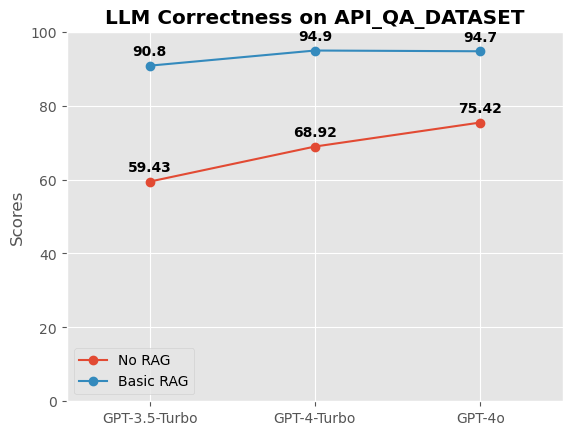

In [16]:
# Create the animation with save functionality
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

# Data for the curve plot
models = ['GPT-3.5-Turbo', 'GPT-4-Turbo', 'GPT-4o']
no_rag = [59.43, 68.92, 75.42]
basic_rag = [90.8, 94.9, 94.7]

# Convert model names to positions
x = np.arange(len(models))

# Plotting
plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.patch.set_facecolor('white')  # Set the background color to white

# Initialize the plot with empty data
line1, = ax.plot([], [], marker='o', label='No RAG')
line2, = ax.plot([], [], marker='o', label='Basic RAG')

ax.set_xlim(-0.5, len(models) - 0.5)
ax.set_ylim(0, 100)
ax.set_ylabel('Scores')
ax.set_title('LLM Correctness on API_QA_DATASET', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Function to initialize the plot
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

# Function to animate the plot
def animate(i):
    line1.set_data(x[:i+1], no_rag[:i+1])
    line2.set_data(x[:i+1], basic_rag[:i+1])
    return line1, line2

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=len(models), init_func=init, blit=True, interval=500)

# Display the plot with value labels
for i, (no_rag_val, basic_rag_val) in enumerate(zip(no_rag, basic_rag)):
    ax.annotate(f'{no_rag_val}', xy=(i, no_rag_val), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontweight='bold')
    ax.annotate(f'{basic_rag_val}', xy=(i, basic_rag_val), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom', fontweight='bold')

# Mark model names
# for i, model in enumerate(models):
#     ax.text(i, -5, model, ha='center', va='top', fontsize=10, color='black', weight='bold', rotation=30)

# Save the animation
ani.save('animation.gif', writer='imagemagick')

plt.show()
